In [6]:
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [7]:
with open('siparis.json',encoding="utf8") as f:
    data = json.load(f)


In [8]:
df = pd.DataFrame(data,columns = ['Comment','Brand','Sector'])
len(df)

98342

In [9]:
filter = df["Comment"] != ""


In [10]:
filter.value_counts()

True    98342
Name: Comment, dtype: int64

In [11]:
df = df[filter]
len(df)

98342

In [12]:
df = df.dropna() 
len(df)

98342

#  Konu Basliklari

In [ ]:
df["Sector"] = df.Brand.map(lambda sentences: None )

In [13]:
yemek_list = ["Yemek Sepeti","Domino's Pizza","Protein Market"]
for i in yemek_list:
    df.Sector[df.Brand == i ] = "Yemek"

In [14]:
filter = df["Sector"] != ""
filter.value_counts()

False    95865
True      2477
Name: Sector, dtype: int64

In [15]:
df = df[filter]
len(df)

2477

In [16]:
df1 = df.dropna()
df1.Sector.value_counts()

Yemek    2477
Name: Sector, dtype: int64

# Alt Konu Basliklari

In [17]:
data_yemek = df1.Comment[df.Sector == "Yemek"]


In [18]:
print("Yemek =>",len(data_yemek))  


Yemek => 2477


In [19]:
def word_tokenize(sentence):
    acronym_each_dot = r"(?:[a-zğçşöüı]\.){2,}"
    acronym_end_dot = r"\b[a-zğçşöüı]{2,3}\."
    suffixes = r"[a-zğçşöüı]{3,}' ?[a-zğçşöüı]{0,3}"
    numbers = r"\d+[.,:\d]+"
    any_word = r"[a-zğçşöüı]+"
    punctuations = r"[a-zğçşöüı]*[.,!?;:]"
    word_regex = "|".join([acronym_each_dot,acronym_end_dot,suffixes,numbers,any_word,punctuations])
    sentence = re.compile("%s"%word_regex, re.I).findall(sentence)
    return sentence

In [20]:
def initial_clean(text):
    #text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case text
    #print(text)
    text = nltk.word_tokenize(text)
    return text

In [21]:
initial_clean('verdiğim')

['verdiğim']

In [22]:
#!/usr/bin/env python
import re

def deEmoji(text):

    emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    return str(emoji_pattern.sub('', text) )# no emoji

In [23]:
text = "Son aldığım ürün henüz elime ulaşmadı"
initial_clean(text)
['son', 'aldığım', 'ürün', 'henüz', 'elime', 'ulaşmadı']

['son', 'aldığım', 'ürün', 'henüz', 'elime', 'ulaşmadı']

In [24]:
#Türkçe için stopwords listesi
with open('turkce-stop-words', 'r') as f:
    myList = [line.strip() for line in f]

In [25]:
def remove_stop_words(text):
    stop_words = myList 
    return [word for word in text if word not in stop_words]

In [26]:
def apply_all(text):
    return remove_stop_words(initial_clean(deEmoji(text)))

In [27]:
import time
t1 = time.time()
data_yemek_clean= data_yemek.apply(apply_all) #kirli veri seti ->>>> normalize edilmiş veri seti
t2 = time.time()
print("prerocess ve tokenize için geçen süre", len(data_yemek), "texts:", (t2-t1)/60, "min") 

prerocess ve tokenize için geçen süre 2477 texts: 0.0625940481821696 min


In [28]:
data_yemek_clean = data_yemek_clean.map(lambda values: ' '.join([str(elem) for elem in values]) )      

In [33]:
# Bu satirdan once asagidaki Normalization satirlarini calistir
data_yemek_clean = data_yemek_clean.map(lambda values: Zemberek_lemmatization(values) )

In [34]:
len(data_yemek_clean)

2477

# Normalization

In [29]:
#https://medium.com/@melikebektas95/zemberek-k%C3%BCt%C3%BCphanesi-ile-t%C3%BCrk%C3%A7e-metinlerde-kelime-k%C3%B6klerinin-bulunmas%C4%B1-6ddd3a875d5f
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java

In [30]:
ZEMBEREK_PATH = r'C:\Users\yasin\Desktop\NLP course\zemberek-full.jar'
startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))

In [31]:
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()

In [32]:
kelimeler = 'arabacı ilişkilendiremediklerimiz gözlük gözlem'
def Zemberek_lemmatization(text):
    analysis: java.util.ArrayList = (
        morphology.analyzeAndDisambiguate(text).bestAnalysis()
        )
    #pos: List[str] = []
    stemma: List[str] = []

    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}'
        f'\nPrimary POS (Short Form) {i}: {analysis.getPos().shortForm}'

        #pos.append( f'{str(analysis.getLemmas()[0])}')
        stemma.append(f'{str(analysis.getStems()[0])}')
    #print(f'\n Kelime Kökleri: {" ".join(pos)}')
    #print(f'\n Kelime Kökleri: {" ".join(stemma)}')
    return " ".join(stemma)


# LDA

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = open('turkce-stop-words', 'r',encoding ='utf-8').read().split()
cv = CountVectorizer(max_df=0.5,min_df=5, stop_words=stop_words)
dtm  = cv.fit_transform(data_yemek_clean)

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=1,random_state=None)

lda_fit  = lda.fit(dtm)

# understanding each topics top 10 common words  
for id_value, value in enumerate(lda_fit.components_):
    print(f"The topic would be {id_value}") 
    print([cv.get_feature_names()[index] for index in value.argsort()   [-50:]])
    print("\n")

The topic would be 0
['uygula', 'durum', '10', 'geri', 'çık', 'çalış', 'getir', 'ücret', 'kullan', 'numara', 'iş', 'zaman', '30', 'hizmet', 'ulaş', 'kargo', 'restoran', 'telefon', 'üzeri', 'bekle', 'yaz', 'tl', 'di', 'tarih', 'firma', '2020', 'iste', 'gönder', 'domino', 'şikayet', 'geç', 'müşteri', 'öde', 'ürün', 'yok', 'dakika', 'iade', 'gün', 'söyle', 'saat', 'şube', 'iptal', 'et', 'al', 'pizza', 'para', 'sepet', 'ara', 'ed', 'yemek']




In [37]:
word_list: List[str] = []
count = 0
for i in data_yemek:
    if ' para' in i:
        word_list.append(i)
        #print(i+"\n===============================================")
        count = count+1
print("Count = ", count)   

Count =  776


In [38]:
df_model = pd.DataFrame(df1,columns = ["Comment","Brand","Sector","Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"])


len(df_model)

2477

In [39]:
konu_list = ["Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"]


In [40]:
for i in konu_list:
    df_model[i] = df_model[i].map(lambda a: 0)

In [41]:
df_yemek = df_model[df_model.Sector == "Yemek"]


In [127]:
df_yemek.head()

,Comment,Brand,Sector,Zamaninda Teslimat,Ödeme,Müşteri Hizmetleri,Kampanya,Doğru Sipariş,İade,Ürün Memnuniyeti
60,Saat 01:04 te verdiğim sipariş için tam 32 dak...,Domino's Pizza,Yemek,1,0,0,0,0,0,0
64,Ben Samsun'dayken Yemek Sepeti'nden 3 tane dür...,Yemek Sepeti,Yemek,0,0,0,0,0,0,1
67,Bu akşam saat 22.15 sularında Ankara Eryaman ş...,Yemek Sepeti,Yemek,1,0,0,0,0,1,0
75,Popeyes'den sipariş verdim. 40 dakika sonra Ye...,Yemek Sepeti,Yemek,1,0,0,0,0,0,0
76,Saat 22:13 de Domino's Pizza Gebze mutlukent ş...,Domino's Pizza,Yemek,1,0,0,1,0,1,0


# Yemek

In [43]:
def check_value(sentence,anahtar):
    for word in anahtar:
        if word in sentence:
            return 1
    return 0  

In [44]:
anahtar = [" saat"," dakika","gün geçti"] 
df_yemek["Zamaninda Teslimat"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

In [45]:
anahtar = [" para"," tl "," ödeme"," kredi"] 
df_yemek["Ödeme"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

In [46]:
anahtar = ["kampanya","kupon"] 
df_yemek["Kampanya"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

In [47]:
anahtar = ["yanlış"] 
df_yemek["Doğru Sipariş"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

In [48]:
anahtar = ["para","iade","saat"] 
df_yemek["İade"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

In [49]:
anahtar = ["sos","sucuk","tavuk"," bol ","peynir","domates","sosis","eksik","malzeme","patates","hamur"] 
df_yemek["Ürün Memnuniyeti"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

In [50]:
anahtar = ["müşteri hizmetleri"] 
df_yemek["Müşteri Hizmetleri"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

In [51]:
df_yemek_comments_labels = df_yemek[["Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"]]
df_yemek_comments_labels.head()

,Zamaninda Teslimat,Ödeme,Müşteri Hizmetleri,Kampanya,Doğru Sipariş,İade,Ürün Memnuniyeti
60,1,0,0,0,0,0,0
64,0,0,0,0,0,0,1
67,1,0,0,0,0,1,0
75,1,0,0,0,0,0,0
76,1,0,0,1,0,1,0


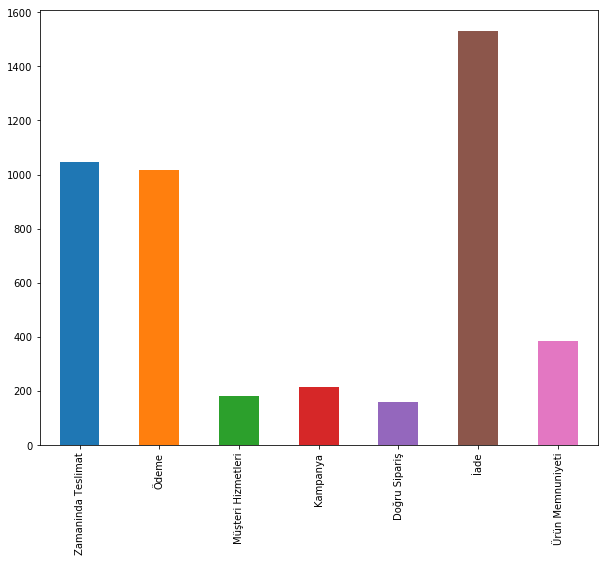

In [52]:
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_yemek_comments_labels.sum(axis=0).plot.bar()

In [89]:
X = []
sentences = list(df_yemek["Comment"])
for sen in sentences:
    X.append(sen)

y = df_yemek_comments_labels.values

In [66]:
len(df_yemek["Comment"])

2477

In [82]:
#df_yemek["Comment"]

In [84]:
train_df = df_yemek.iloc[400:]
test_df = df_yemek.iloc[:400]

In [112]:
train_labels = y[400:]
test_labels = y[:400]

In [113]:
print(len(train_labels))
print(len(test_labels))


2077
400


# Create TF-IDF Vectorizer

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

vectorizer = TfidfVectorizer()
vectorised_train_documents = vectorizer.fit_transform(train_df["Comment"])
vectorised_test_documents = vectorizer.transform(test_df["Comment"])

In [126]:
vectorised_train_documents

<2077x19575 sparse matrix of type '<class 'numpy.float64'>'
	with 126449 stored elements in Compressed Sparse Row format>

In [115]:
type(vectorised_train_documents)

scipy.sparse.csr.csr_matrix

# Visualize Word Frequency Distribution

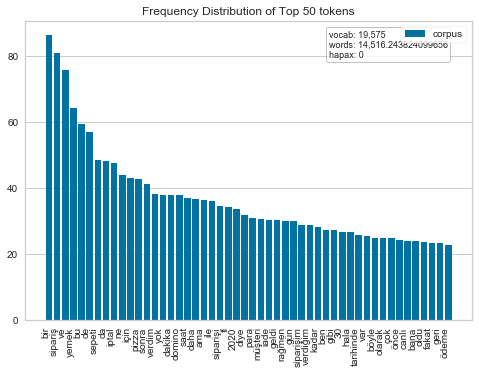

In [116]:
from yellowbrick.text import FreqDistVisualizer
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(vectorised_train_documents)
visualizer.show()

# Visualize the dataset with T-SNE

In [105]:
from yellowbrick.text import TSNEVisualizer

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


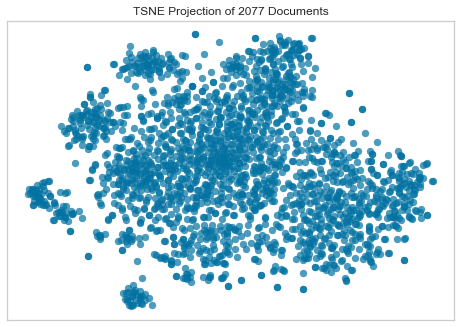

In [106]:
tsne = TSNEVisualizer()
tsne.fit(vectorised_train_documents)
tsne.show()

# Train and Evaluate Classifiers

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1

# KNN Classifier¶


In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

knnClf = KNeighborsClassifier()

knnClf.fit(vectorised_train_documents, train_labels)
knnPredictions = knnClf.predict(vectorised_test_documents)
metricsReport("knn", test_labels, knnPredictions)

------knn Model Metrics-----
Accuracy: 0.2750
Hamming Loss: 0.1746
Precision:
  - Macro: 0.5187
  - Micro: 0.6764
Recall:
  - Macro: 0.4030
  - Micro: 0.6329
F1-measure:
  - Macro: 0.4323
  - Micro: 0.6539


# Decision Tree Classifier¶


In [118]:
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(vectorised_train_documents, train_labels)
dtPreds = dtClassifier.predict(vectorised_test_documents)
metricsReport("Decision Tree", test_labels, dtPreds)

------Decision Tree Model Metrics-----
Accuracy: 0.4950
Hamming Loss: 0.0996
Precision:
  - Macro: 0.7073
  - Micro: 0.8453
Recall:
  - Macro: 0.6229
  - Micro: 0.7562
F1-measure:
  - Macro: 0.6610
  - Micro: 0.7983


# Bagging

In [119]:

from sklearn.ensemble import BaggingClassifier

bagClassifier = OneVsRestClassifier(BaggingClassifier(n_jobs=-1))
bagClassifier.fit(vectorised_train_documents, train_labels)
bagPreds = bagClassifier.predict(vectorised_test_documents)
metricsReport("Bagging", test_labels, bagPreds)

------Bagging Model Metrics-----
Accuracy: 0.7700
Hamming Loss: 0.0371
Precision:
  - Macro: 0.8807
  - Micro: 0.9384
Recall:
  - Macro: 0.8490
  - Micro: 0.9178
F1-measure:
  - Macro: 0.8637
  - Micro: 0.9280


# Random Forrest

In [120]:
from sklearn.ensemble import RandomForestClassifier
rfClassifier = RandomForestClassifier(n_jobs=-1)
rfClassifier.fit(vectorised_train_documents, train_labels)
rfPreds = rfClassifier.predict(vectorised_test_documents)
metricsReport("Random Forest", test_labels, rfPreds)

C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


------Random Forest Model Metrics-----
Accuracy: 0.3400
Hamming Loss: 0.1464
Precision:
  - Macro: 0.6413
  - Micro: 0.8187
Recall:
  - Macro: 0.3145
  - Micro: 0.5630
F1-measure:
  - Macro: 0.3732
  - Micro: 0.6672


C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Boosting

In [121]:
from sklearn.ensemble import GradientBoostingClassifier

boostClassifier = OneVsRestClassifier(GradientBoostingClassifier())
boostClassifier.fit(vectorised_train_documents, train_labels)
boostPreds = boostClassifier.predict(vectorised_test_documents)
metricsReport("Boosting", test_labels, boostPreds)

------Boosting Model Metrics-----
Accuracy: 0.7050
Hamming Loss: 0.0511
Precision:
  - Macro: 0.8861
  - Micro: 0.9427
Recall:
  - Macro: 0.7891
  - Micro: 0.8562
F1-measure:
  - Macro: 0.8321
  - Micro: 0.8973


# Naive Bayes Classifier

In [122]:
from sklearn.naive_bayes import MultinomialNB

nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(vectorised_train_documents, train_labels)

nbPreds = nbClassifier.predict(vectorised_test_documents)
metricsReport("Multinomial NB", test_labels, nbPreds)

------Multinomial NB Model Metrics-----
Accuracy: 0.2625
Hamming Loss: 0.1668
Precision:
  - Macro: 0.3575
  - Micro: 0.7279
Recall:
  - Macro: 0.2807
  - Micro: 0.5753
F1-measure:
  - Macro: 0.2921
  - Micro: 0.6427


C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Support Vector Machine (Linear SVC)

In [123]:
from sklearn.svm import LinearSVC

svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(vectorised_train_documents, train_labels)

svmPreds = svmClassifier.predict(vectorised_test_documents)
metricsReport("SVC Sq. Hinge Loss", test_labels, svmPreds)

------SVC Sq. Hinge Loss Model Metrics-----
Accuracy: 0.5150
Hamming Loss: 0.0943
Precision:
  - Macro: 0.9114
  - Micro: 0.8795
Recall:
  - Macro: 0.5509
  - Micro: 0.7397
F1-measure:
  - Macro: 0.6528
  - Micro: 0.8036


*Linear SVC with Squarred hinge loss seems to outperfom all the previously seen models                                          
*SVCs are much more robust against Correlated features

In [124]:
from skmultilearn.problem_transform import LabelPowerset

powerSetSVC = LabelPowerset(LinearSVC())
powerSetSVC.fit(vectorised_train_documents, train_labels)

powerSetSVCPreds = powerSetSVC.predict(vectorised_test_documents)
metricsReport("Power Set SVC", test_labels, powerSetSVCPreds)

------Power Set SVC Model Metrics-----
Accuracy: 0.4025
Hamming Loss: 0.1332
Precision:
  - Macro: 0.8474
  - Micro: 0.8010
Recall:
  - Macro: 0.4230
  - Micro: 0.6507
F1-measure:
  - Macro: 0.4993
  - Micro: 0.7181


# Comparison on different models based on their Micro-F1 score

In [125]:
print("  Model Name " + " "*10 + "| Micro-F1 Score")
print("-------------------------------------------")
for key, value in ModelsPerformance.items():
    print("  " + key, " "*(20-len(key)) + "|", value)
    print("-------------------------------------------")

  Model Name           | Micro-F1 Score
-------------------------------------------
  knn                  | 0.6539278131634819
-------------------------------------------
  Decision Tree        | 0.7982646420824295
-------------------------------------------
  Bagging              | 0.9279778393351802
-------------------------------------------
  Random Forest        | 0.6672077922077921
-------------------------------------------
  Boosting             | 0.8973438621679828
-------------------------------------------
  Multinomial NB       | 0.6426931905126243
-------------------------------------------
  SVC Sq. Hinge Loss   | 0.8035714285714286
-------------------------------------------
  Power Set SVC        | 0.7180650037792895
-------------------------------------------
